<a href="https://colab.research.google.com/github/AdrianMPCodes/AMP-and-RZ---Is-Good-Music-Biased-Predicting-Grammy-Winning-Albums/blob/main/AMP_%26_RZ_Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# imports
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error, f1_score
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

In [ ]:
df_training = pd.read_csv("https://github.com/AdrianMPCodes/AMP-and-RZ---Is-Good-Music-Biased-Predicting-Grammy-Winning-Albums/blob/main/Data%20Collection%20and%20Cleaning/df_combinedVariables.csv?raw=true")
df_training

,artists,type,sex,album_name,won,num_of_tracks,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,Santana,Group,Male,Supernatural,True,14,0.582786,0.792071,7.071429,-6.360286,0.428571,0.059243,0.206586,0.191212,0.179429,0.734000,112.041000,319684.714286
1,TLC,Group,Female,FanMail,False,17,0.691765,0.620059,5.764706,-7.341235,0.529412,0.159865,0.073153,0.021650,0.213459,0.607824,114.408765,223631.294118
2,The Chicks,Group,Female,Fly,False,13,0.593846,0.591192,4.153846,-8.442769,1.000000,0.035015,0.207601,0.001895,0.154046,0.568231,129.986462,220581.461538
3,Backstreet Boys,Group,Male,Millennium,False,12,0.643000,0.618417,4.833333,-6.766333,0.500000,0.030092,0.217875,0.000001,0.184825,0.511167,120.629417,230227.750000
4,Diana Krall,Person,Female,When I Look in Your Eyes,False,13,0.532000,0.166946,5.769231,-16.167308,0.538462,0.040623,0.877846,0.017048,0.123092,0.326000,109.450923,250796.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134,Coldplay,Group,Male,Music of the Spheres,False,12,0.419075,0.562008,3.583333,-11.275250,0.666667,0.053567,0.375252,0.330368,0.258567,0.216550,140.935750,209217.750000
135,Beyonce,Person,Female,Renaissance,False,16,0.729500,0.665750,4.000000,-7.248938,0.687500,0.138194,0.062996,0.003560,0.260787,0.429656,117.673000,233856.937500
136,Lizzo,Person,Female,Special,False,12,0.693000,0.672417,5.916667,-5.537500,0.416667,0.078292,0.109871,0.000001,0.217617,0.658500,116.024917,176376.916667
137,Bad Bunny,Person,Male,Un Verano Sin Ti,False,23,0.756652,0.657391,5.304348,-6.060696,0.478261,0.119965,0.258104,0.000249,0.216961,0.484826,118.279391,213529.173913


In [ ]:
# Loading in data
df_training = pd.read_csv("https://github.com/AdrianMPCodes/AMP-and-RZ---Is-Good-Music-Biased-Predicting-Grammy-Winning-Albums/blob/main/Data%20Collection%20and%20Cleaning/df_combinedVariables.csv?raw=true")
X_train = df_training.drop(columns = ["won"])
y_train = df_training["won"]

testing_url = "https://github.com/AdrianMPCodes/AMP-and-RZ---Is-Good-Music-Biased-Predicting-Grammy-Winning-Albums/blob/main/Data%20Collection%20and%20Cleaning/df_test_combinedVariables.csv?raw=true"
X_test = pd.read_csv(testing_url)

### Defining functions needed for recursive proccess

In [ ]:
# Create column transformer based on desired features
def createColTrans(features): #instead of features, call it curVars
  col_trans = []

  for feat in features:
    name = "scaler" + feat
    if (type(df_training[feat][0]) == np.float64):
      col_trans.append((name, StandardScaler(), [feat]))
    if (type(df_training[feat][0]) == str):
      col_trans.append((name, TfidfVectorizer(smooth_idf=False, norm=None), feat)) #max_features=k??

  column_transformer = ColumnTransformer(col_trans)
  return column_transformer


In [ ]:
# Creates modifiable column transformer based on desired scaler
def modifyColTrans(scaler, features):
  col_trans = []

  for feat in features:
    name = "scaler" + feat
    if (type(df_training[feat][0]) == np.float64):
      col_trans.append((name, scaler, [feat]))
    if (type(df_training[feat][0]) == str):
      col_trans.append((name, TfidfVectorizer(smooth_idf=False, norm=None), feat)) #max_features=k??

  column_transformer = ColumnTransformer(col_trans)
  return column_transformer

In [ ]:
def createPipeline(col_transformer, model):
  pipeline = make_pipeline(
      col_transformer, 
      model
  )
  return pipeline

In [ ]:
def createCrossValue(pipeline, currentVariablesModel):
  score = np.mean(cross_val_score(
    pipeline,
    X = df_training[currentVariablesModel],
    y = y_train,
    scoring="f1",
    cv=4
  ))
  
  return score 

In [ ]:
allPossibleVariables = ["duration_ms", "instrumentalness", 
                  "key", "liveness","loudness", "tempo"]
allCombinations = []
def generate_combinations(start, curr_combination):
    if start == len(allPossibleVariables):
        allCombinations.append(curr_combination)
    else: # Recursion: include current element in the combination or exclude it
        generate_combinations(start + 1, curr_combination + [allPossibleVariables[start]])
        generate_combinations(start + 1, curr_combination)
    return allCombinations

In [ ]:
def get_best_features(model):
  # Gets every possible combination of variables
  allCombinations = generate_combinations(0, ["album_name", "acousticness", "sex", "valence", "danceability", "energy", "artists"]) 
  # know we'll use "album", no need to recurse thru options w/o it
  allScores = []
  #createColTrans(["album_name","artists", "acousticness"])
  for variableCombo in allCombinations: # Must go through 127 choices
    cur_ColTrans = createColTrans(variableCombo)
    cur_Pipe = createPipeline(cur_ColTrans, model)
    cur_CrossVal = createCrossValue(cur_Pipe, variableCombo)
    allScores.append(cur_CrossVal)

  # Get feats w/ max f1
  sortedScores = sorted(allScores)
  max_index = allScores.index(sortedScores[len(sortedScores)-1])
  return allCombinations[max_index]

KNN Classifier vs. Decision Tree Classifier 

### Implementing recursion to get best features

In [ ]:
# KNN
knn = KNeighborsClassifier(n_neighbors=20, metric="euclidean")
best_feats_knn = get_best_features(knn)
best_feats_knn

['album_name',
 'acousticness',
 'sex',
 'valence',
 'danceability',
 'energy',
 'artists',
 'duration_ms',
 'instrumentalness',
 'key',
 'liveness',
 'loudness',
 'tempo']

In [ ]:
# Decision Tree
dec_tree = DecisionTreeClassifier()
best_feats_dec_tree = get_best_features(dec_tree)
best_feats_dec_tree

['album_name',
 'acousticness',
 'sex',
 'valence',
 'danceability',
 'energy',
 'artists',
 'duration_ms',
 'liveness',
 'loudness']

In [ ]:
# Define best column transformer
best_col_trans_knn = createColTrans(best_feats_knn)
best_col_trans_dec_tree = createColTrans(best_feats_dec_tree)

## Creating best knn model

### Best scaler & metrics

In [ ]:
scalers = [StandardScaler(), Normalizer(), MinMaxScaler()]
metrics = ["euclidean", "minkowski", "manhattan"]

scores = []
allCombs = []

for scaler in scalers:
  col_trans = modifyColTrans(scaler, best_feats_knn)

  for metric in metrics:
    pipeline = make_pipeline(
      col_trans, 
      KNeighborsClassifier(n_neighbors=20, metric=metric)
    )

    score = createCrossValue(pipeline, best_feats_knn)
    scores.append(score)
    
    allCombs.append([scaler, metric])

# Get minimum error
max_index = scores.index(sorted(scores)[len(scores)-1])

# Define best pipeline
best_scaler_knn = allCombs[max_index][0]
best_metric_knn = allCombs[max_index][1]
pipeline_knn = make_pipeline(
    modifyColTrans(best_scaler_knn, best_feats_knn),
    KNeighborsClassifier(n_neighbors=20, metric=best_metric_knn)
    )

In [ ]:
allCombs[max_index]

[StandardScaler(), 'euclidean']

### Best hyperparams

In [ ]:
# Get best K and best metric
from sklearn.model_selection import GridSearchCV

k_range = range(1, 20)
grid_k = GridSearchCV(
    pipeline_knn,
    param_grid={"kneighborsclassifier__n_neighbors": k_range 
                },
    scoring= "f1",
    cv=4, 
    return_train_score = True
)

grid_k.fit(X_train, y_train)
best_k = grid_k.best_params_
score_knn = grid_k.best_score_
print(best_k)
print(score_knn)

{'kneighborsclassifier__n_neighbors': 7}
0.14285714285714285


<Axes: >

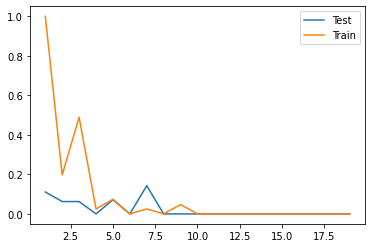

In [ ]:
# Visualizing the k w/ the lowest error
df_error = pd.DataFrame({"Test": grid_k.cv_results_["mean_test_score"],
                         "Train": grid_k.cv_results_["mean_train_score"]},
                        index = k_range)
df_error.plot.line(legend=True)

## Creating best decision tree model

### Best scalers - decision tree

In [ ]:
# Decision tree
scalers = [StandardScaler(), Normalizer(), MinMaxScaler()]

scores = []

for scaler in scalers:
  col_trans = modifyColTrans(scaler, best_feats_dec_tree)
  pipeline = make_pipeline(
      col_trans, 
      DecisionTreeClassifier()
      )
  score = createCrossValue(pipeline, best_feats_dec_tree)
  scores.append(score)

# Get max f1
max_index = scores.index(sorted(scores)[len(scores)-1])

# Define pipeline
best_scaler_dec_tree = scalers[max_index]
best_pipeline_dec_tree = make_pipeline(
    modifyColTrans(best_scaler_dec_tree, best_feats_knn),
    DecisionTreeClassifier()
    )

In [ ]:
best_scaler_dec_tree

StandardScaler()

In [ ]:
# Get best score
grid_dec_tree = GridSearchCV(
    best_pipeline_dec_tree,
    param_grid={"decisiontreeclassifier__criterion": ("gini", "entropy", "log_loss"),
                "decisiontreeclassifier__splitter": ("best", "random")
                },
    scoring= "f1",
    cv=4, 
    n_jobs = 10,
    return_train_score = True
)

grid_dec_tree.fit(X_train, y_train)
best_params = grid_dec_tree.best_params_
score_dec_tree = grid_dec_tree.best_score_
print(best_params)
print(score_dec_tree)

{'decisiontreeclassifier__criterion': 'log_loss', 'decisiontreeclassifier__splitter': 'best'}
0.20714285714285713


## Applying the better model

In [ ]:
# Create best model from gridCV
best_pipeline_dec_tree = createPipeline(best_col_trans_dec_tree, 
                                   DecisionTreeClassifier(criterion = "entropy", splitter="random"))
best_pipeline_dec_tree.fit(X_train, y_train)

# Predicting on y
y_preds = best_pipeline_dec_tree.predict(X_test)
y_preds_proba = best_pipeline_dec_tree.predict_proba(X_test) #array of lists, each list has 2 probabilities

# Printing the DataFrame
df_preds = pd.DataFrame()
df_preds["artists"] = X_test["artists"]
df_preds["won"] = y_preds
df_preds

,artists,won
0,Paramore,False
1,Yo La Tengo,False
2,The Murder Capital,True
3,Robert Forster,True
4,"James Yorkston, Nina Persson, and The Second H...",False
5,Kelela,False
6,Gaz Coombes,False
7,Young Fathers,False
8,Ryuichi Sakamoto,False
9,Caroline Polachek,False


#### Probability Correlation for Training and Testing

<Axes: >

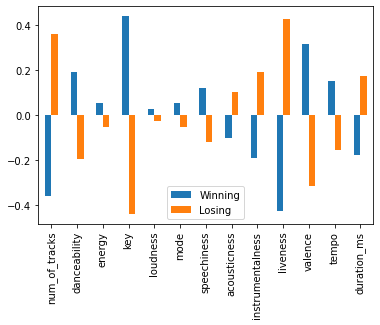

In [ ]:
df_probs = X_test.copy()

prob_lose = []
prob_win = []

for p in y_preds_proba:
  prob_lose.append(p[0])
  prob_win.append(p[1])

df_probs["lose_prob"] = prob_lose
df_probs["win_prob"] = prob_win

win_corrs = []
lose_corrs = []

# correlations: each factor's correlation with winning probability

for c in X_train.columns:
  win_corrs.append(min(df_probs[[c, "win_prob"]].corr().min()))
  lose_corrs.append(min(df_probs[[c, "lose_prob"]].corr().min()))

# Visualizing the k w/ the lowest error
# cut off non-quantitative values
win_corrs = win_corrs[4:]
lose_corrs = lose_corrs[4:]
cols = X_train.columns[4:]
data = pd.DataFrame({"Winning": win_corrs,
                         "Losing": lose_corrs},
                        index = cols)
data.plot.bar(legend=True)

In [ ]:
# Confirming our findings
import pandas as pd
import plotly.graph_objects as go

# create a sample DataFrame
df = pd.DataFrame({
    'artists': X_test["artists"],
    'danceability': X_test["danceability"],
    'energy': X_test["energy"],
    'valence': X_test["valence"],
    'album_name': X_test["album_name"],
    'key': X_test["key"],
    'loudness': X_test["loudness"],
    'mode': X_test["mode"],
    'speechiness': X_test["speechiness"],
    'acousticness': X_test["acousticness"],
    'instrumentalness': X_test["instrumentalness"],
    'liveness': X_test["liveness"],
    'tempo': X_test["tempo"],
    'duration_ms': X_test["duration_ms"]
})

# create a list of y-variable names
y_vars = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']

# create a list to hold the figures
figs = []

# create a separate figure for each y-variable
for y_var in y_vars:
    fig = go.Figure()
    fig.add_trace(go.Bar(x=df['album_name'], y=df[y_var]))
    fig.update_layout(title=f'{y_var} by Album Name', xaxis_title='Album Name', yaxis_title=y_var)
    figs.append(fig)

# display the figures
for fig in figs:
    fig.show()